# Gaussian Processes for Yield Prediction - Wheat

In [8]:
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import geopandas as gpd
import matplotlib.pyplot as plt

import warnings
import pickle

%reload_ext autoreload
%autoreload 2

from utils import *
from gaussian_processes import GaussianProcess

az.style.use('arviz-whitegrid')

In [9]:
# Set random seed
np.random.seed(42)

## Load and build the dataset

In [10]:
# Load the dataset
cy = pd.read_csv('data/yield_processed.csv', index_col=0)
cy = cy[cy['Item'] == 'Wheat'].drop(columns='Item').reset_index(drop=True)

# Get geodata for plot world map
countries = cy['Area'].unique()
world = get_geodata(countries)

# Get the features and the target feature
cy = cy.drop('Area', axis=1)
print(cy.describe())
x_data = cy.drop('hg/ha_yield', axis=1).to_numpy()
y_data = cy['hg/ha_yield'].to_numpy()

# Set the indices of the sample for testing
num_test_results = 10
test_indices = np.random.choice(len(y_data), size=num_test_results, replace=False)
test_indices = np.sort(test_indices)
train_indices = np.array([i for i in range(len(y_data)) if i not in test_indices])

# Standardize the data
x_std_data, x_mean, x_stddev = standardize_data(x_data)
y_std_data, y_mean, y_stddev = standardize_data(y_data)

# Get 10 samples to plot
x_test_std_data, y_test_std_data = x_std_data[test_indices], y_std_data[test_indices]

y_data_full = y_data.copy()
x_test_data, y_test_data = x_data[test_indices], y_data[test_indices]

n_samples, n_features = x_std_data.shape
x_std_data.shape, y_std_data.shape, x_test_std_data.shape, y_test_std_data.shape

        hg/ha_yield  avg_rain_mm_per_year  pesticides_kg_per_ha   avg_temp  \
count     82.000000             82.000000             82.000000  82.000000   
mean   30830.865532            904.634146            186.528693  16.389268   
std    20220.774362            617.961574            255.859296   6.927212   
min     5574.130435             51.000000              0.120619   3.459565   
25%    16741.019928            536.250000             18.118719   9.832554   
50%    24589.978261            695.500000             85.286504  16.817174   
75%    41989.315217           1218.000000            245.303045  21.324022   
max    84988.615385           3240.000000           1414.555032  29.718696   

             lat         lon         elev  
count  82.000000   82.000000    82.000000  
mean   22.939943   17.304159   687.780488  
std    28.745417   49.114882   617.341393  
min   -41.000000 -102.000000    28.000000  
25%     1.000000    4.437500   314.000000  
50%    29.000000   21.000000   48

((82, 6), (82,), (10, 6), (10,))

## Exponential quadratic kernel

<font size=5>
Change from Gamma to HalfNormal for Length Scale

In [12]:
# Build a PyMC3 GP regression model
with pm.Model() as model:
    # Instantiate a hyper-prior on the covariance function's parameter
    ls = pm.HalfNormal('ls', 1.0, shape=n_features)
    # Instantiate the covariance function
    cov = pm.gp.cov.ExpQuad(n_features, ls) + pm.gp.cov.WhiteNoise(1e-5)
    # Instantiate the GP marginal variable
    gp = pm.gp.Marginal(cov_func=cov)
    eps = pm.HalfCauchy('eps', 1.0)
    # Likelihood
    y_pred = gp.marginal_likelihood('y_pred', X=x_std_data, y=y_std_data, noise=eps)
    gp_model = GaussianProcess(model=model, gp=gp)

In [13]:
# Sample from posterior
with model:
    trace = pm.sample(
        draws=32_000, tune=16_000,
        chains=2, cores=1, random_seed=42,
        return_inferencedata=True,
        target_accept=0.95
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [eps, ls]


Sampling 2 chains for 16_000 tune and 32_000 draw iterations (32_000 + 64_000 draws total) took 2563 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


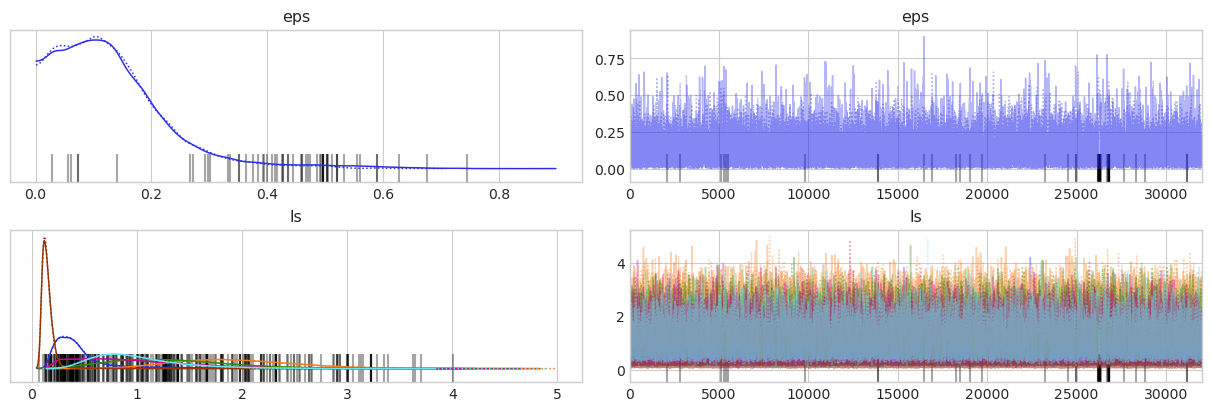

In [16]:
plot_trace(trace, ['eps', 'ls'])

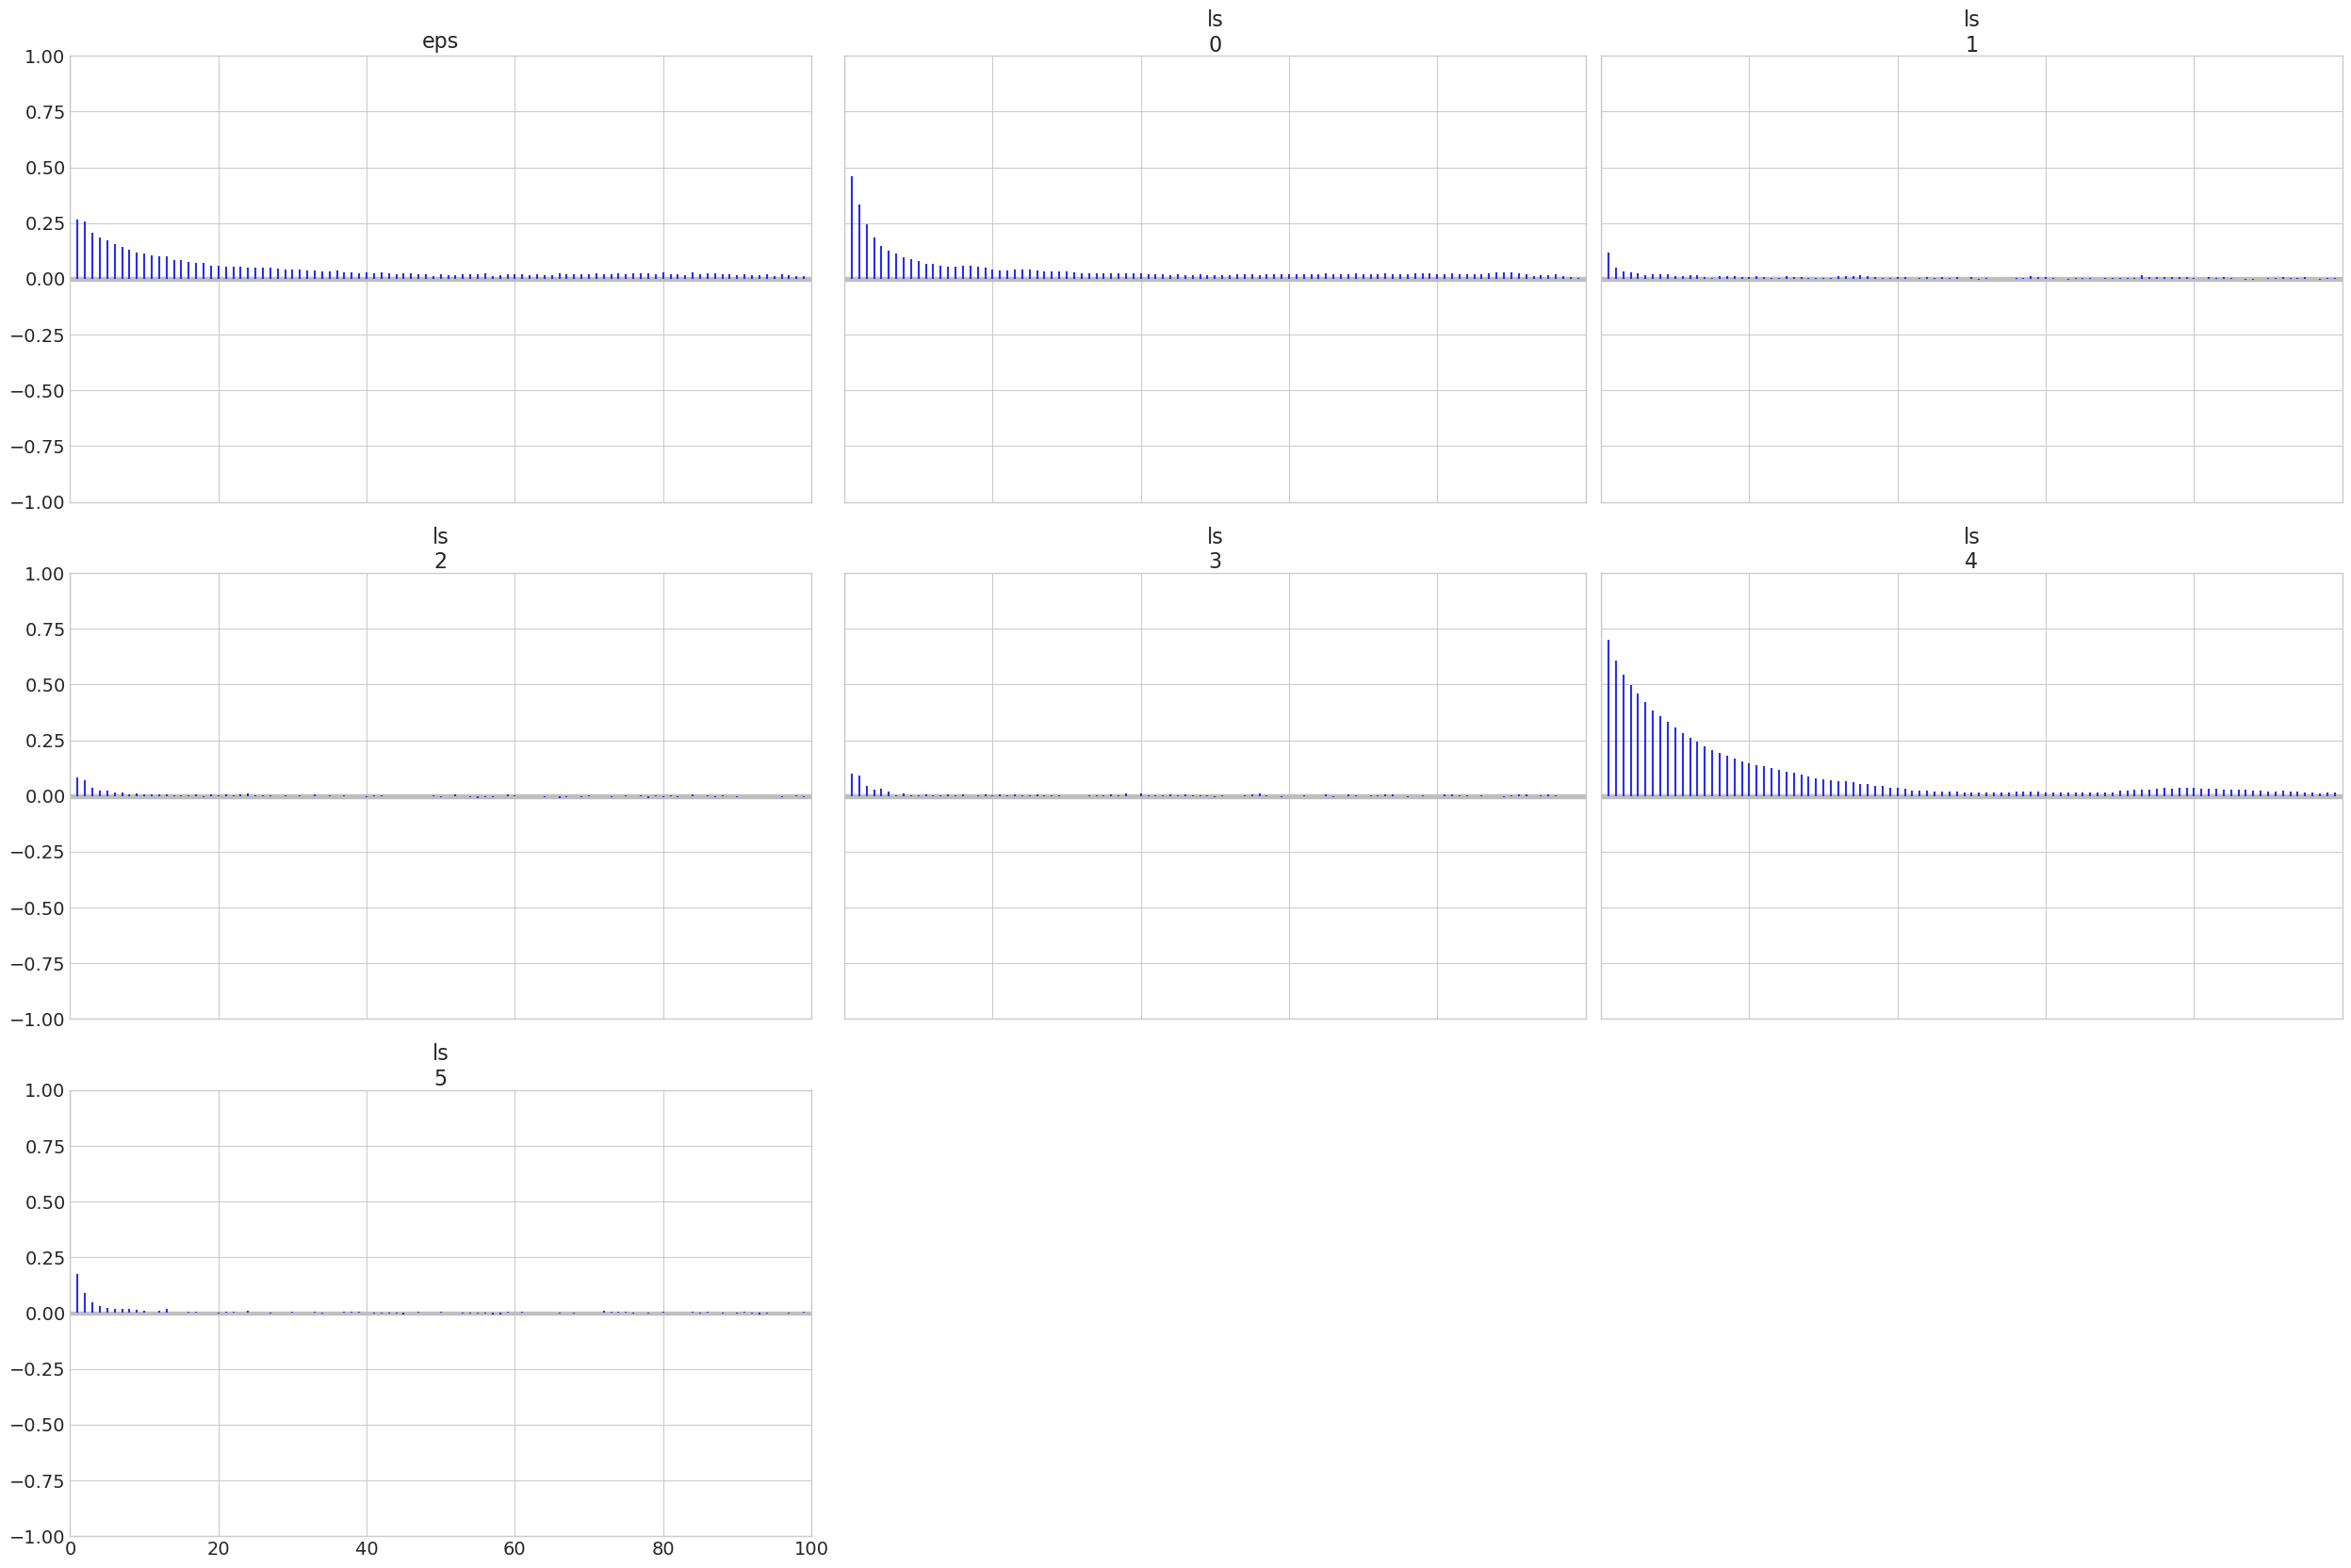

In [17]:
az.plot_autocorr(trace, var_names=['eps', 'ls'], combined=True)
plt.show()

In [18]:
pred_samples = gp_model.sample_conditional(trace, x_std_data, 'f_pred', num_pred_samples=2048)

C:\Users\PasqualeDeMarinis\.conda\envs\pymc_env\lib\site-packages\pymc3\distributions\posterior_predictive.py:248: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


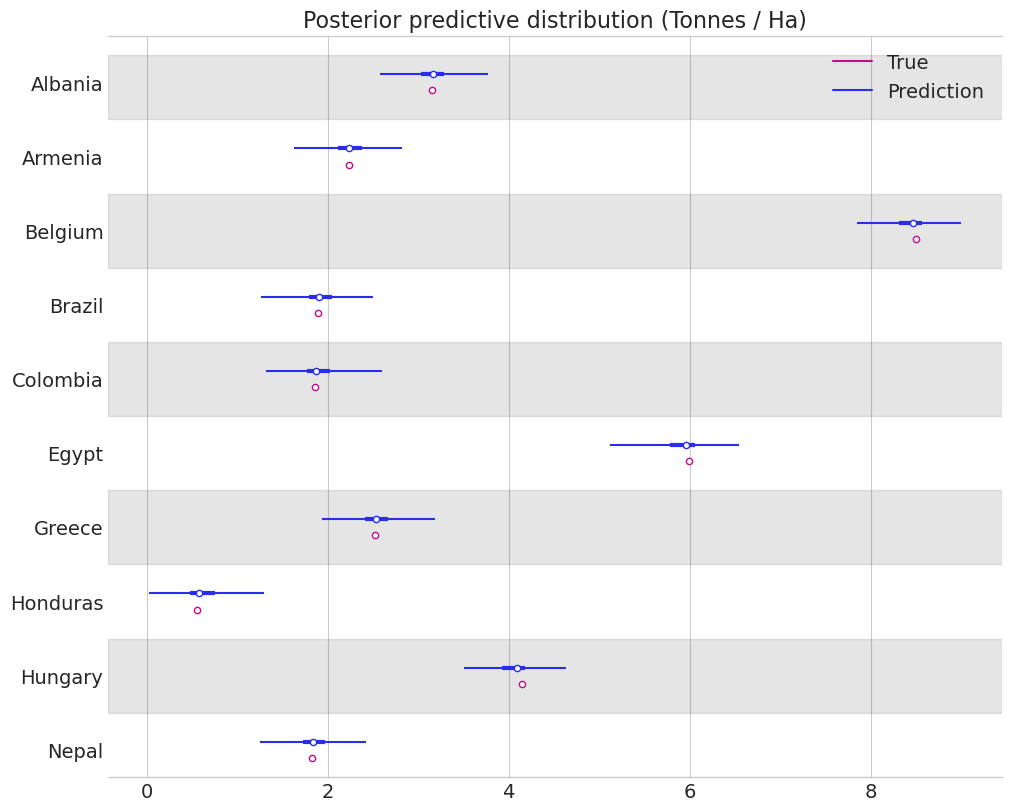

In [19]:
plot_test(pred_samples[:, test_indices], y_mean, y_stddev,
          y_test_data, countries[test_indices])

In [20]:
mae, r2 = compute_metrics(pred_samples, y_mean, y_stddev, y_data)

R2 : 0.9997642685354577
MAE: 185.34645438695406


[]

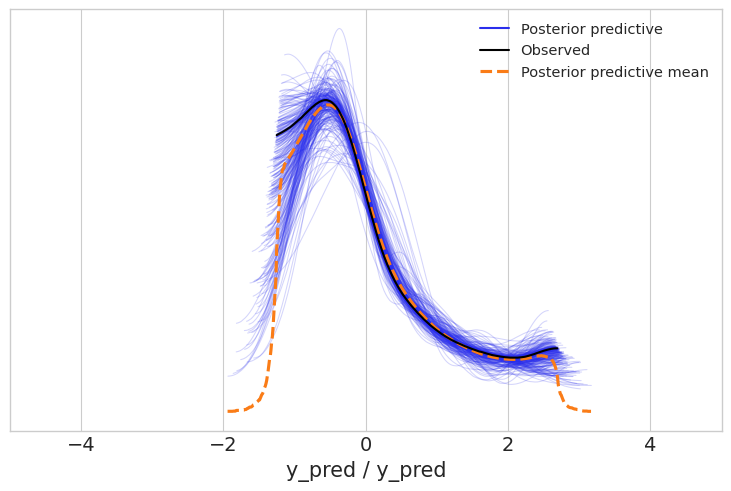

In [21]:
ppc_data = az.from_pymc3(posterior_predictive={'y_pred':pred_samples}, model=model)
ax = az.plot_ppc(ppc_data, num_pp_samples=256)
ax.set_xlim((-5, 5))
plt.plot()

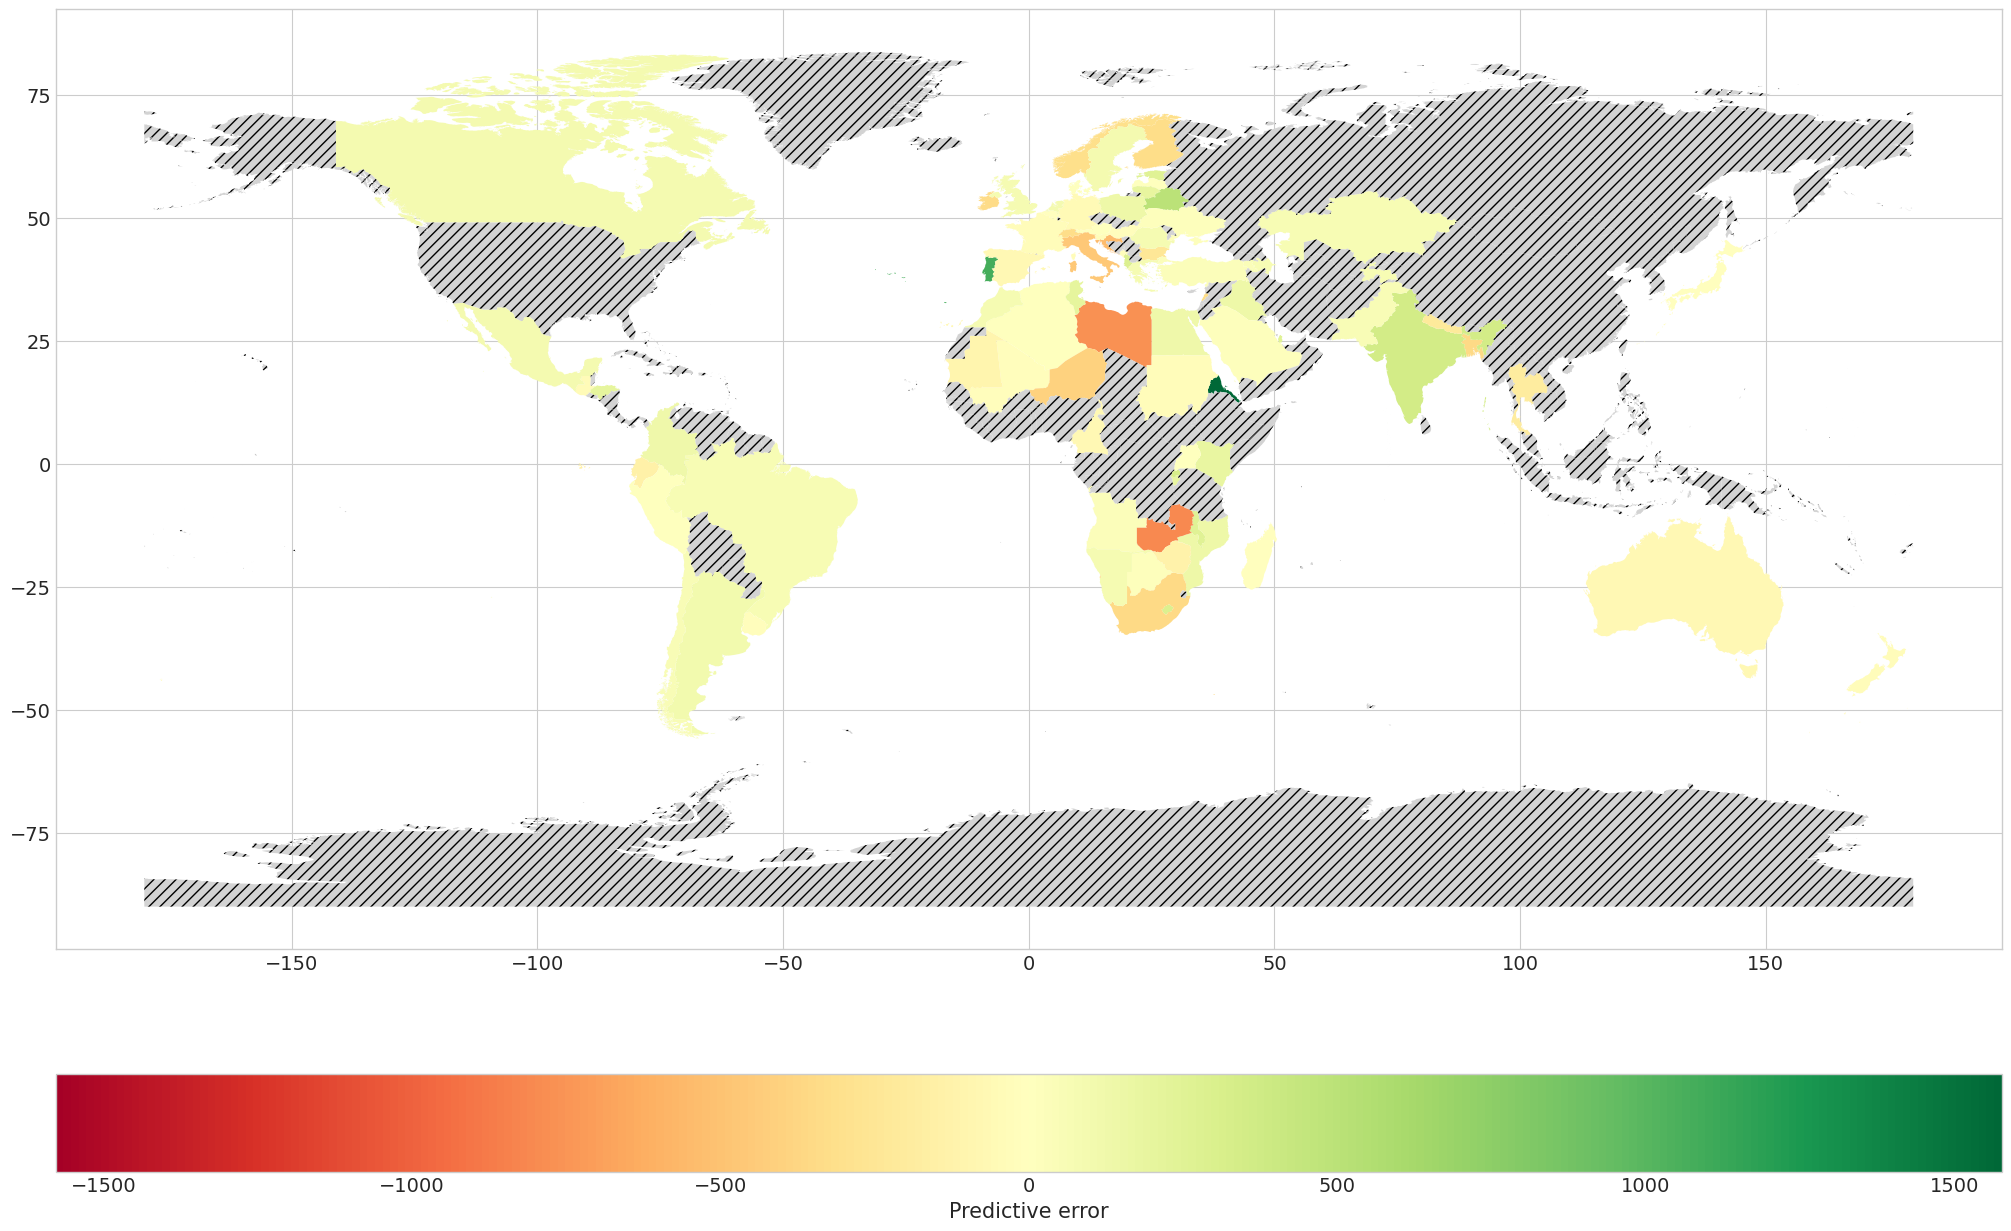

In [22]:
world_error_plot(world, pred_samples, y_mean, y_stddev, y_data)

In [23]:
results['expquad'] = {
    'trace': trace,
    'pred_samples': pred_samples,
    'mae': mae,
    'r2': r2,
}

## Polynomial kernel, grade 2

In [18]:
# Build a PyMC3 GP regression model
with pm.Model() as model:
    # Instantiate a hyper-prior on the covariance function's parameter
    offset = pm.Normal('offset', 0, 8)
    c = pm.Normal('c', 0, 8, shape=n_features)
    grade = 2
    # Instantiate the covariance function
    cov = pm.gp.cov.Polynomial(n_features, c=c, d=grade, offset=offset) + pm.gp.cov.WhiteNoise(1e-5)
    # Instantiate the GP marginal variable
    gp = pm.gp.Marginal(cov_func=cov)
    eps = pm.HalfCauchy('eps', 5.0)
    # Likelihood
    y_pred = gp.marginal_likelihood('y_pred', X=x_std_data, y=y_std_data, noise=eps)
    gp_model = GaussianProcess(model=model, gp=gp)

In [19]:
# Sample from posterior
with model:
    trace = pm.sample(
        draws=16_000, tune=8_000,
        chains=2, cores=1, random_seed=42,
        return_inferencedata=True,
        target_accept=0.9
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [eps, c, offset]


Sampling 2 chains for 8_000 tune and 16_000 draw iterations (16_000 + 32_000 draws total) took 2828 seconds.
There were 13919 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8354897898402874, but should be close to 0.9. Try to increase the number of tuning steps.
There were 26537 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


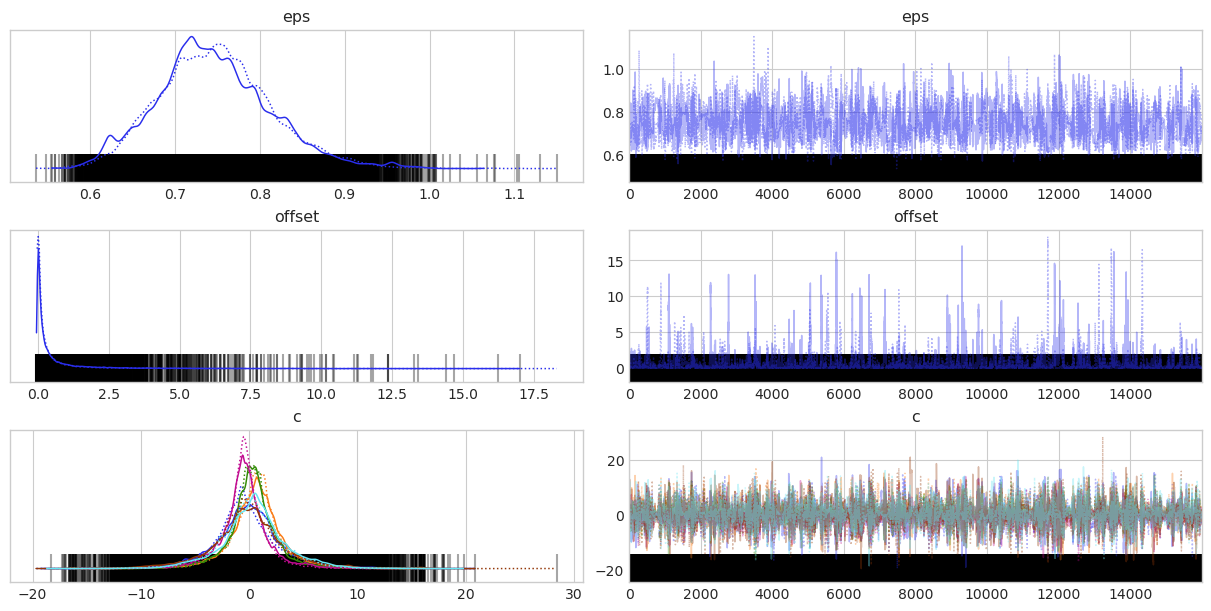

In [20]:
plot_trace(trace, ['eps', 'offset', 'c'])

In [21]:
pred_samples = gp_model.sample_conditional(trace, x_std_data, 'f_pred')
plot_test(pred_samples[test_indices].T, y_mean, y_stddev,
          y_test_data, countries[test_indices])

C:\Users\pasqu\.conda\envs\pymc_env\lib\site-packages\pymc3\distributions\posterior_predictive.py:248: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


LinAlgError: Matrix is not positive definite

In [23]:
results['poly'] = {
    'trace': trace,
    # 'pred_samples': None,
    # 'mae': None,
    # 'r2': None,
}

## Exponential Kernel

In [46]:
# Build a PyMC3 GP regression model
with pm.Model() as model:
    # Instantiate a hyper-prior on the covariance function's parameter
    ls = pm.HalfNormal('ls', 1.0, shape=n_features)
    # Instantiate the covariance function
    cov = pm.gp.cov.Exponential(n_features, ls) + pm.gp.cov.WhiteNoise(1e-5)
    # Instantiate the GP marginal variable
    gp = pm.gp.Marginal(cov_func=cov)
    eps = pm.HalfCauchy('eps', 5.0)
    # Likelihood
    y_pred = gp.marginal_likelihood('y_pred', X=x_std_data, y=y_std_data, noise=eps)
    gp_model = GaussianProcess(model=model, gp=gp)

In [25]:
# Sample from posterior
with model:
    trace = pm.sample(
        draws=32_000, tune=16_000,
        chains=2, cores=1, random_seed=42,
        return_inferencedata=True, target_accept=0.9
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [eps, ls]


Sampling 2 chains for 16_000 tune and 32_000 draw iterations (32_000 + 64_000 draws total) took 2177 seconds.


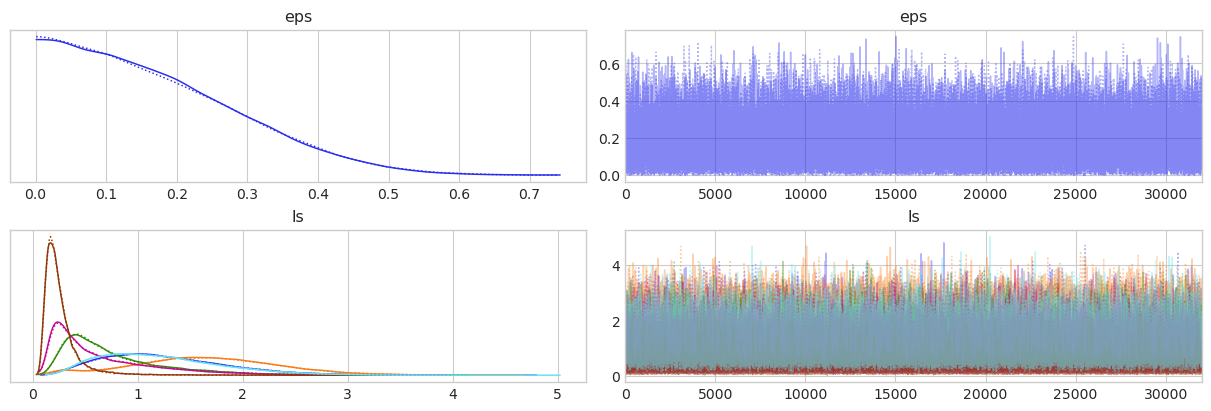

In [26]:
plot_trace(trace, ['eps', 'ls'])

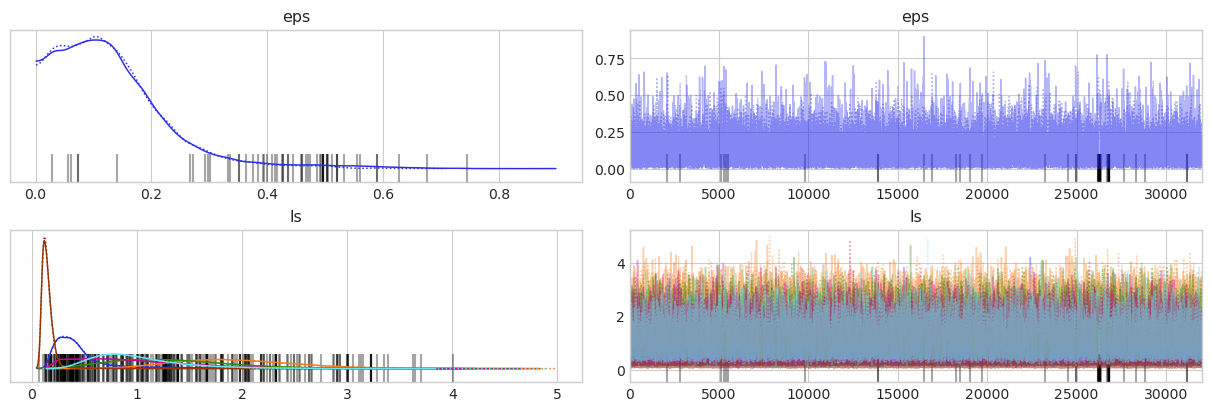

In [14]:
plot_trace(results['expquad']['trace'], ['eps', 'ls'])

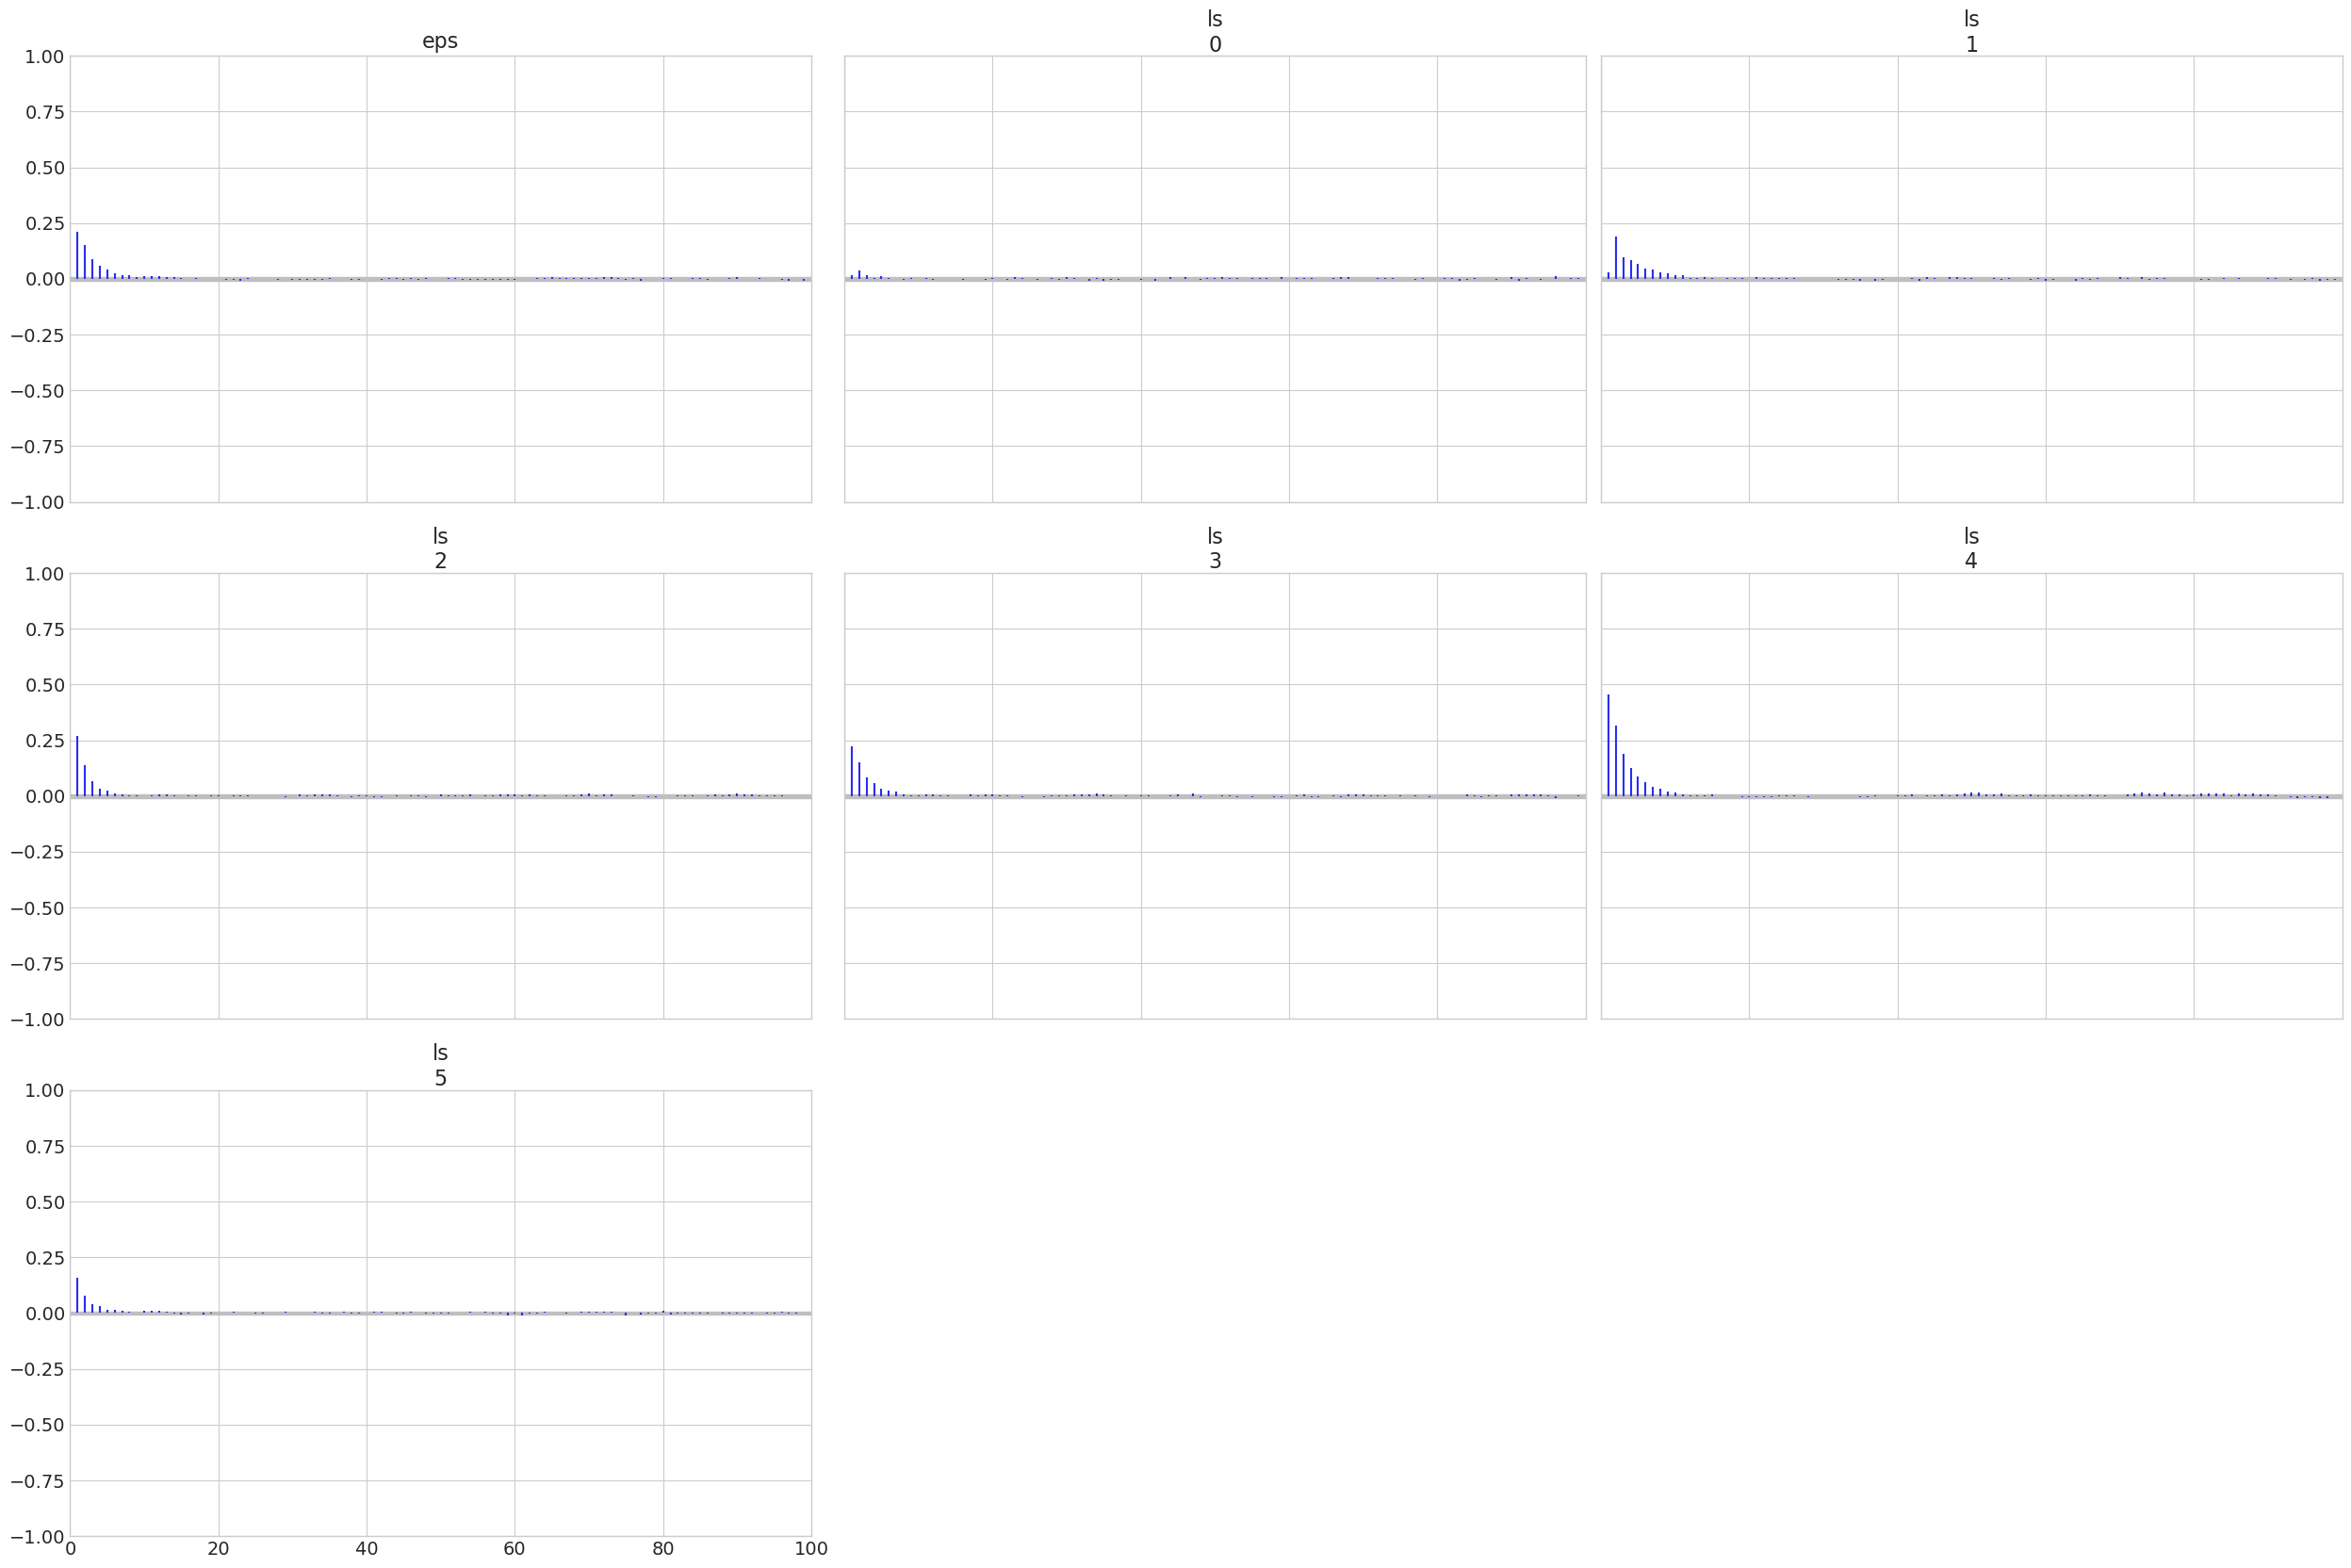

In [27]:
az.plot_autocorr(trace, var_names=['eps', 'ls'], combined=True)
plt.show()

In [30]:
pred_samples = gp_model.sample_conditional(trace, x_std_data, 'f_pred', num_pred_samples=2048)

C:\Users\PasqualeDeMarinis\.conda\envs\pymc_env\lib\site-packages\pymc3\distributions\posterior_predictive.py:248: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


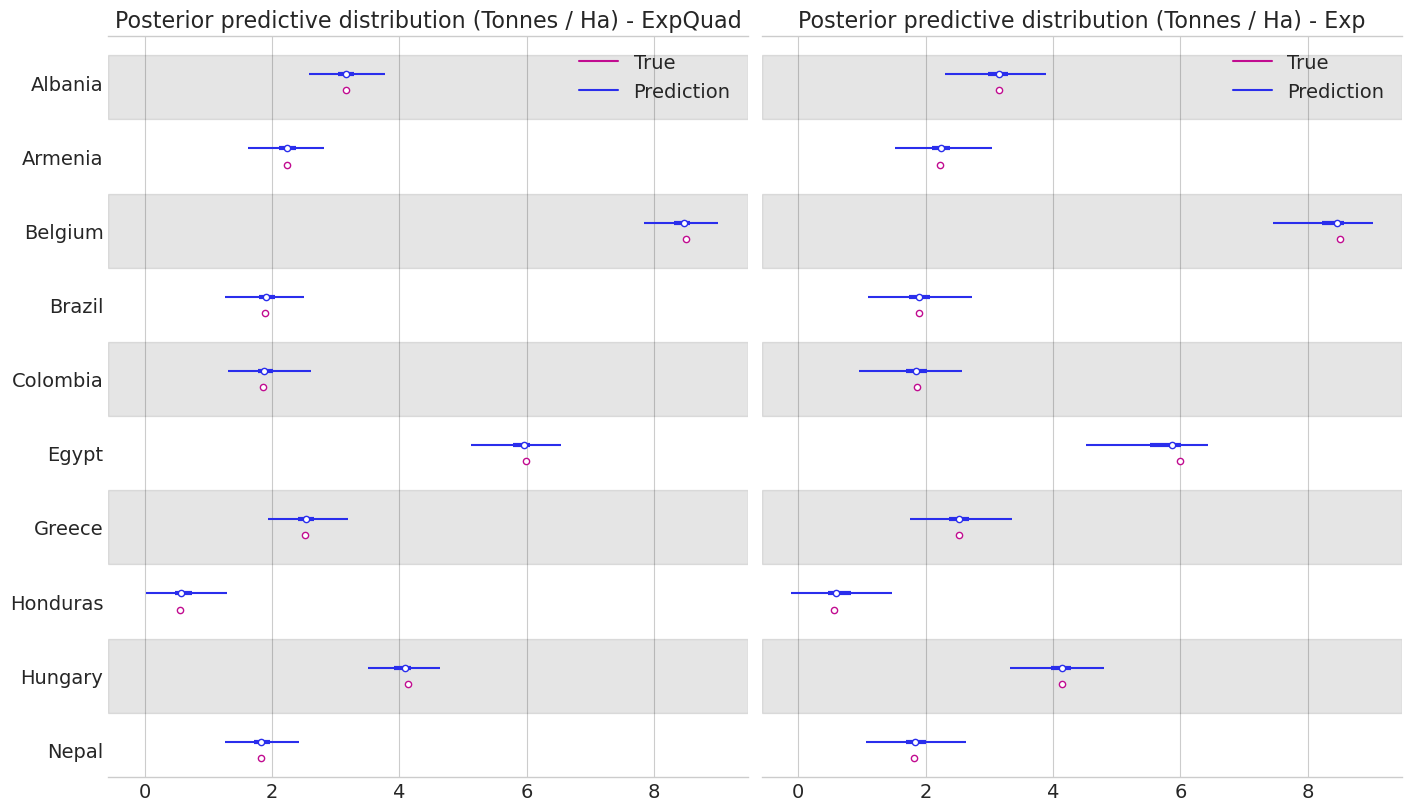

In [47]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 8), sharex=True, sharey=True)
plot_test(results['expquad']['pred_samples'][:, test_indices], y_mean, y_stddev,
          y_test_data, countries[test_indices], axes=ax1, title='Posterior predictive distribution (Tonnes / Ha) - ExpQuad')
plot_test(pred_samples[:, test_indices], y_mean, y_stddev,
          y_test_data, countries[test_indices], axes=ax2, title='Posterior predictive distribution (Tonnes / Ha) - Exp')
plt.show()

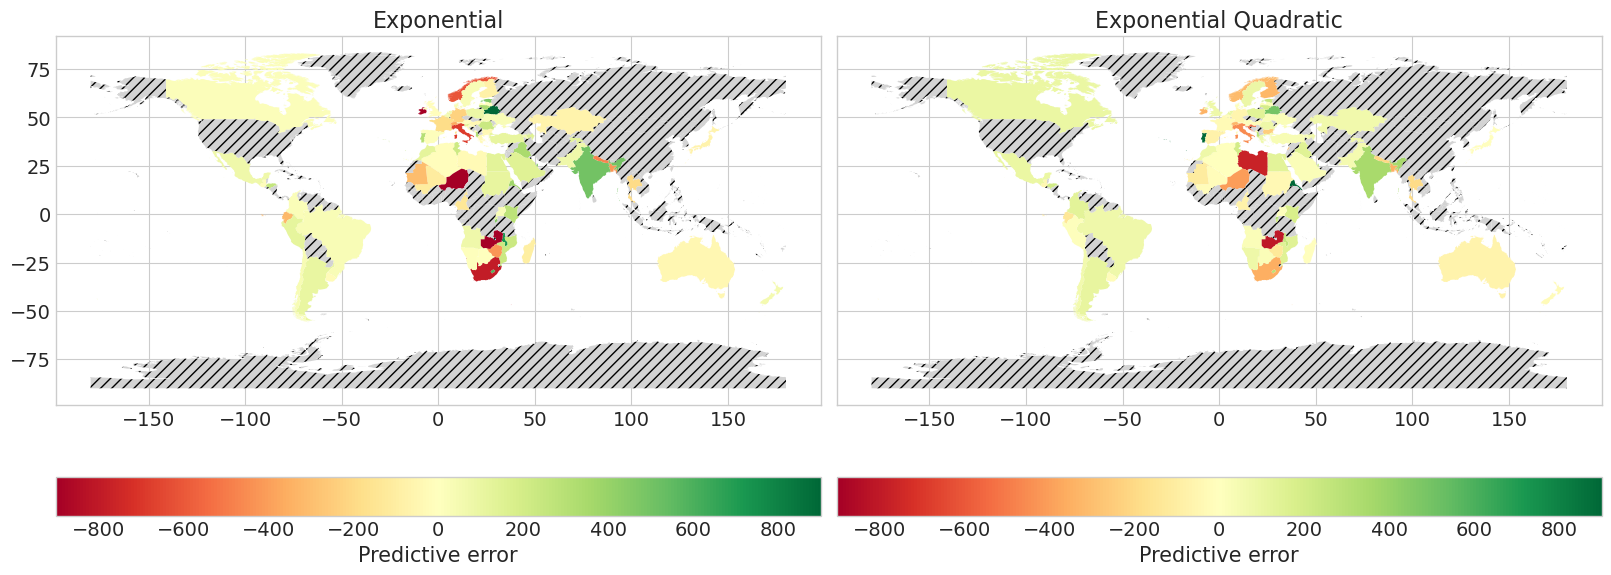

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 10), sharex=True, sharey=True)
ax1.set_title('Exponential')
ax2.set_title('Exponential Quadratic')
world_error_plot(world, results['expquad']['pred_samples'], y_mean, y_stddev, y_data, axes=ax2, max_error=900)
world_error_plot(world, pred_samples, y_mean, y_stddev, y_data, axes=ax1, max_error=900)

In [11]:
mae, r2 = compute_metrics(pred_samples, y_mean, y_stddev, y_data, show=False)
print("R2  ExpQuad: {} \t MAE ExpQuad: {}".format(results['expquad']['r2'], results['expquad']['mae']))
print("R2  Exp    : {} \t MAE Exp    : {}".format(r2, mae))

R2  ExpQuad: 0.9997642685354577 	 MAE ExpQuad: 185.34645438695406
R2  Exp    : 0.9996640142016462 	 MAE Exp    : 228.77249718883292


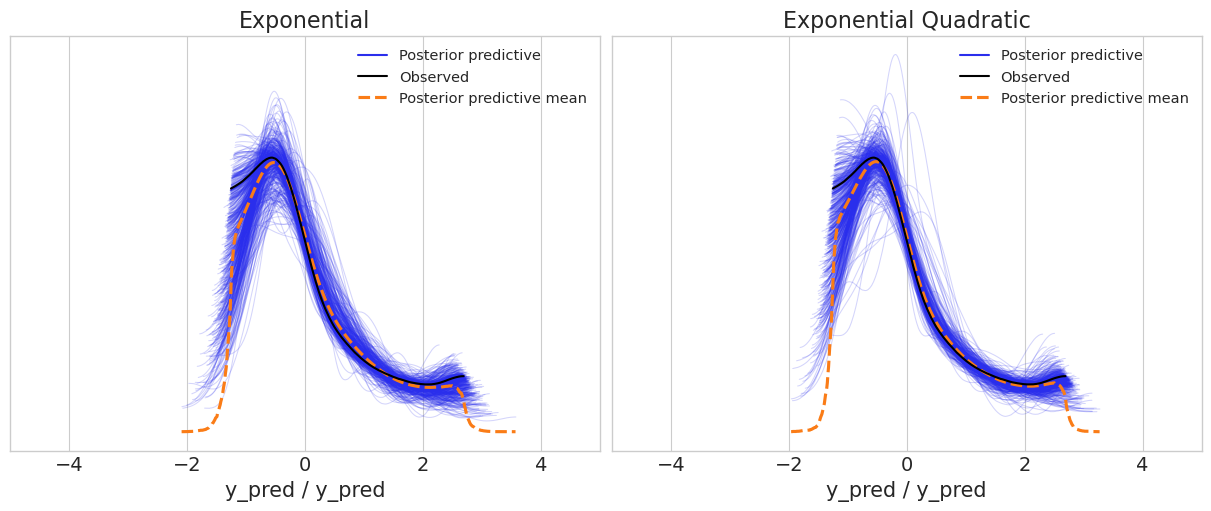

In [31]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5), sharex=True, sharey=True)
ax1.set_title('Exponential')
ax2.set_title('Exponential Quadratic')
ppc_data = az.from_pymc3(posterior_predictive={'y_pred':results['expquad']['pred_samples']}, model=model)
az.plot_ppc(ppc_data, num_pp_samples=512, ax=ax2)
ax2.set_xlim((-5, 5))
plt.plot()

ppc_data = az.from_pymc3(posterior_predictive={'y_pred':pred_samples}, model=model)
az.plot_ppc(ppc_data, num_pp_samples=512, ax=ax1)
ax1.set_xlim((-5, 5))
plt.plot()
plt.show()

In [32]:
results['exp'] = {
    'trace': trace,
    'pred_samples': pred_samples,
    'mae': mae,
    'r2': r2,
}

## RatQuad Kernel

In [16]:
# Build a PyMC3 GP regression model
with pm.Model() as model:
    # Instantiate a hyper-prior on the covariance function's parameter
    ls = pm.HalfNormal('ls', 0.5, shape=n_features)
    alpha = pm.Normal('alpha', 0, 0.5)
    # Instantiate the covariance function
    cov = pm.gp.cov.RatQuad(n_features, ls=ls, alpha=alpha) + pm.gp.cov.WhiteNoise(1e-5)
    # Instantiate the GP marginal variable
    gp = pm.gp.Marginal(cov_func=cov)
    eps = pm.HalfCauchy('eps', 5.0)
    # Likelihood
    y_pred = gp.marginal_likelihood('y_pred', X=x_std_data, y=y_std_data, noise=eps)
    gp_model = GaussianProcess(model=model, gp=gp)

In [17]:
# Sample from posterior
with model:
    trace = pm.sample(
        draws=32_000, tune=16_000,
        chains=2, cores=1, random_seed=42,
        return_inferencedata=True, target_accept=0.95
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
ERROR (theano.graph.opt): SeqOptimizer apply <theano.tensor.opt.FusionOptimizer object at 0x000001A08BA03C40>
ERROR (theano.graph.opt): Traceback:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "C:\Users\PasqualeDeMarinis\.conda\envs\pymc_env\lib\site-packages\theano\scalar\basic.py", line 365, in filter
    raise TypeError(
TypeError: Value cannot accurately be converted to dtype (float64) and allow_downcast is not True

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\PasqualeDeMarinis\.conda\envs\pymc_env\lib\site-packages\theano\graph\opt.py", line 245, in apply
    sub_prof = optimizer.optimize(fgraph)
  File "C:\Users\PasqualeDeMarinis\.conda\envs\pymc_env\lib\site-packages\theano\graph\opt.py", line 83, in optimize
    ret = self.apply(fgraph, *args, **kwargs)
  File "C:\Users\PasqualeDeMarinis\.conda\envs\pymc_e

C:\Users\PasqualeDeMarinis\.conda\envs\pymc_env\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\PasqualeDeMarinis\.conda\envs\pymc_env\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Sampling 1 chain for 199 tune and 0 draw iterations (199 + 0 draws total) took 20 seconds.
No posterior samples. Unable to run convergence checks


---

In [38]:
# Sample from posterior
with model:
    trace = pm.sample(
        draws=32_000, tune=16_000,
        chains=2, cores=1, random_seed=42,
        return_inferencedata=True, target_accept=0.95
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [eps, alpha, ls]


Sampling 2 chains for 16_000 tune and 32_000 draw iterations (32_000 + 64_000 draws total) took 5411 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


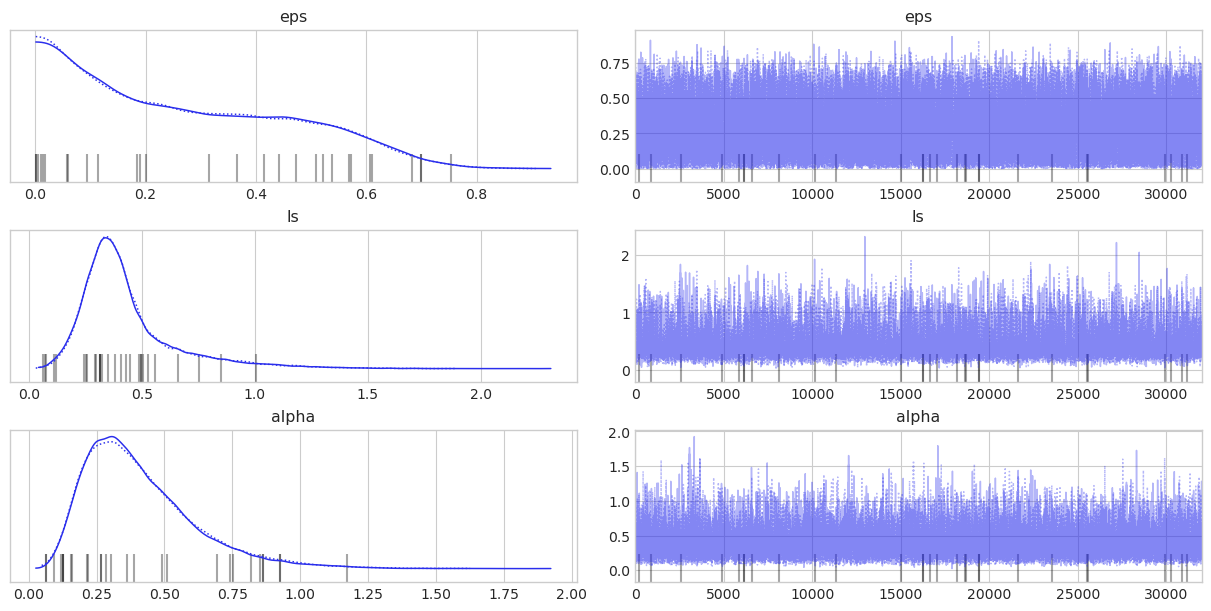

In [39]:
plot_trace(trace, ['eps', 'ls', 'alpha'])

In [18]:
pred_samples = gp_model.sample_conditional(trace, x_std_data, 'f_pred', num_pred_samples=2048)

C:\Users\PasqualeDeMarinis\.conda\envs\pymc_env\lib\site-packages\pymc3\distributions\posterior_predictive.py:248: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


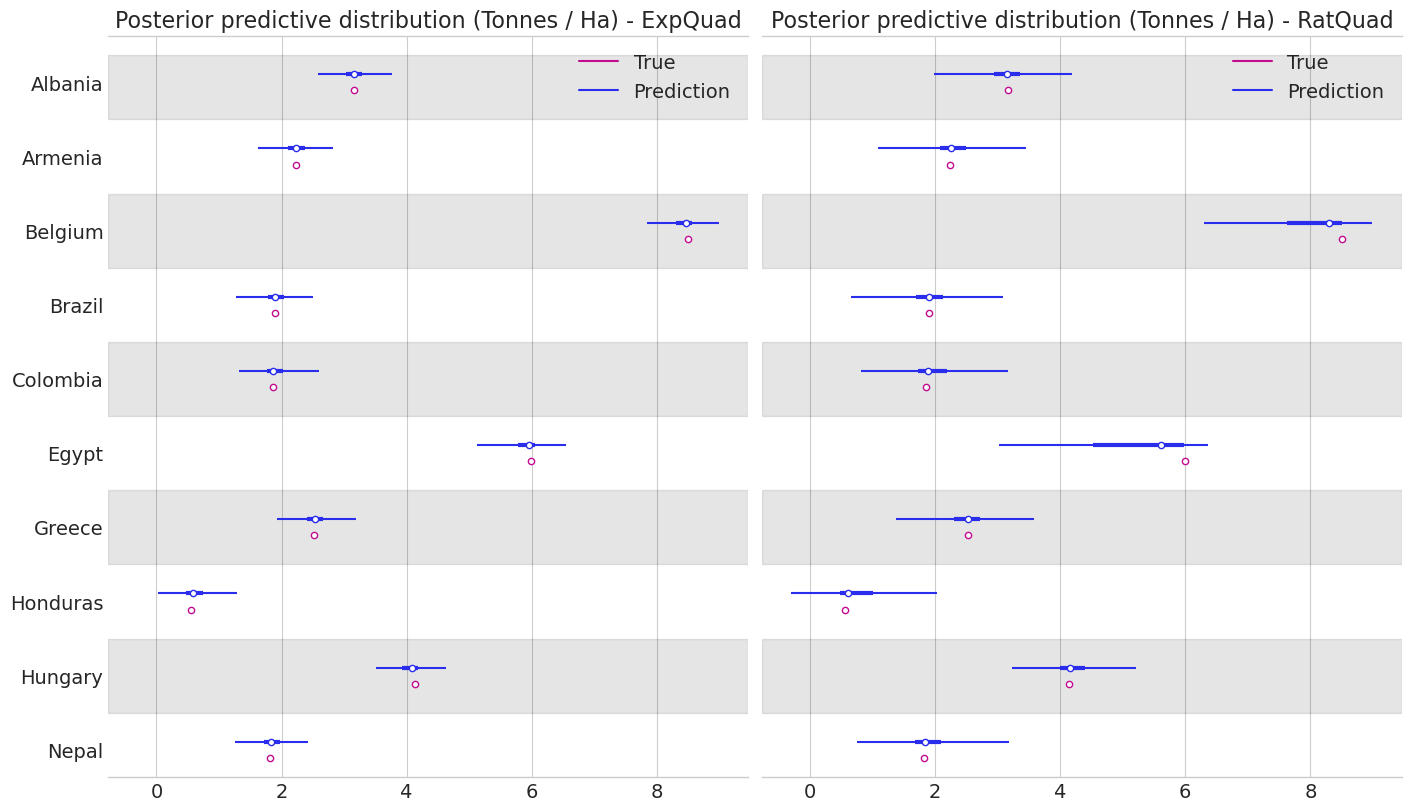

In [19]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 8), sharex=True, sharey=True)
plot_test(results['expquad']['pred_samples'][:, test_indices], y_mean, y_stddev,
          y_test_data, countries[test_indices], axes=ax1, title='Posterior predictive distribution (Tonnes / Ha) - ExpQuad')
plot_test(pred_samples[:, test_indices], y_mean, y_stddev,
          y_test_data, countries[test_indices], axes=ax2, title='Posterior predictive distribution (Tonnes / Ha) - RatQuad')
plt.show()

<font size=5>
    Also here, RatQuad has more uncertain distributions
<br><br>

In [20]:
mae, r2 = compute_metrics(pred_samples, y_mean, y_stddev, y_data, show=False)
print("ExpQuad: R2: {} \t MAE: {}".format(results['expquad']['r2'], results['expquad']['mae']))
print("Exp    : R2: {} \t MAE: {}".format(results['exp']['r2'], results['exp']['mae']))
print("RatQuad: R2: {} \t MAE: {}".format(r2, mae))

ExpQuad: R2: 0.9997642685354577 	 MAE: 185.34645438695406
Exp    : R2: 0.9996265968624055 	 MAE: 267.34241049891403
RatQuad: R2: 0.9973527317672904 	 MAE: 660.51259049484


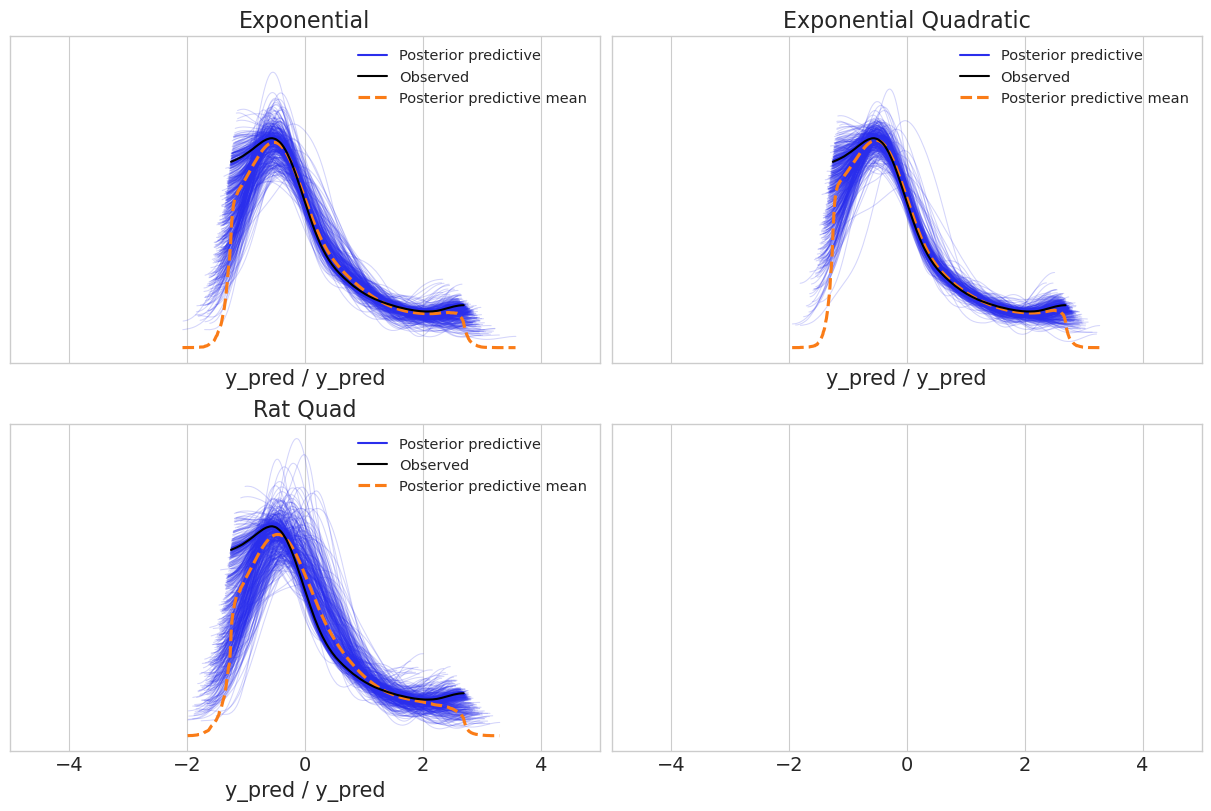

In [34]:
fig, ((ax1, ax2), (ax3, _)) = plt.subplots(ncols=2, nrows=2, figsize=(12, 8), sharex=True, sharey=True)
ax1.set_title('Exponential')
ax2.set_title('Exponential Quadratic')
ax3.set_title('Rat Quad')
ppc_data = az.from_pymc3(posterior_predictive={'y_pred':results['expquad']['pred_samples']}, model=model)
az.plot_ppc(ppc_data, num_pp_samples=512, ax=ax2)
ax2.set_xlim((-5, 5))
plt.plot()

ppc_data = az.from_pymc3(posterior_predictive={'y_pred':results['exp']['pred_samples']}, model=model)
az.plot_ppc(ppc_data, num_pp_samples=512, ax=ax1)
ax1.set_xlim((-5, 5))
plt.plot()

ppc_data = az.from_pymc3(posterior_predictive={'y_pred':pred_samples}, model=model)
az.plot_ppc(ppc_data, num_pp_samples=512, ax=ax3)
ax1.set_xlim((-5, 5))
plt.plot()
plt.show()

In [25]:
results['ratquad'] = {
    'trace': trace,
    'pred_samples': pred_samples,
    'mae': mae,
    'r2': r2,
}

## Combyning kernels - weighted sum

In [35]:
# Build a PyMC3 GP regression model
with pm.Model() as model:
    # Instantiate a hyper-prior on the covariance function's parameter
    ls = pm.HalfNormal('ls', 1.0, shape=n_features)
    c = pm.Normal('c', 0, 8, shape=n_features)
    # Instantiate the covariance function
    w0 = pm.HalfNormal('w0', 5)
    w1 = pm.HalfNormal('w1', 5)
    cov = pm.gp.cov.Exponential(n_features, ls=ls) * w0 + \
        pm.gp.cov.Linear(n_features, c=c) * w1 + \
        pm.gp.cov.WhiteNoise(1e-5) 
    # Instantiate the GP marginal variable
    gp = pm.gp.Marginal(cov_func=cov)
    eps = pm.HalfCauchy('eps', 5.0)
    # Likelihood
    y_pred = gp.marginal_likelihood('y_pred', X=x_std_data, y=y_std_data, noise=eps)
    gp_model = GaussianProcess(model=model, gp=gp)

In [47]:
# Sample from posterior
with model:
    trace = pm.sample(
        draws=32_000, tune=16_000,
        chains=2, cores=1, random_seed=42,
        return_inferencedata=True,
        target_accept=0.9
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [eps, w1, w0, c, ls]


Sampling 2 chains for 16_000 tune and 32_000 draw iterations (32_000 + 64_000 draws total) took 3592 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.


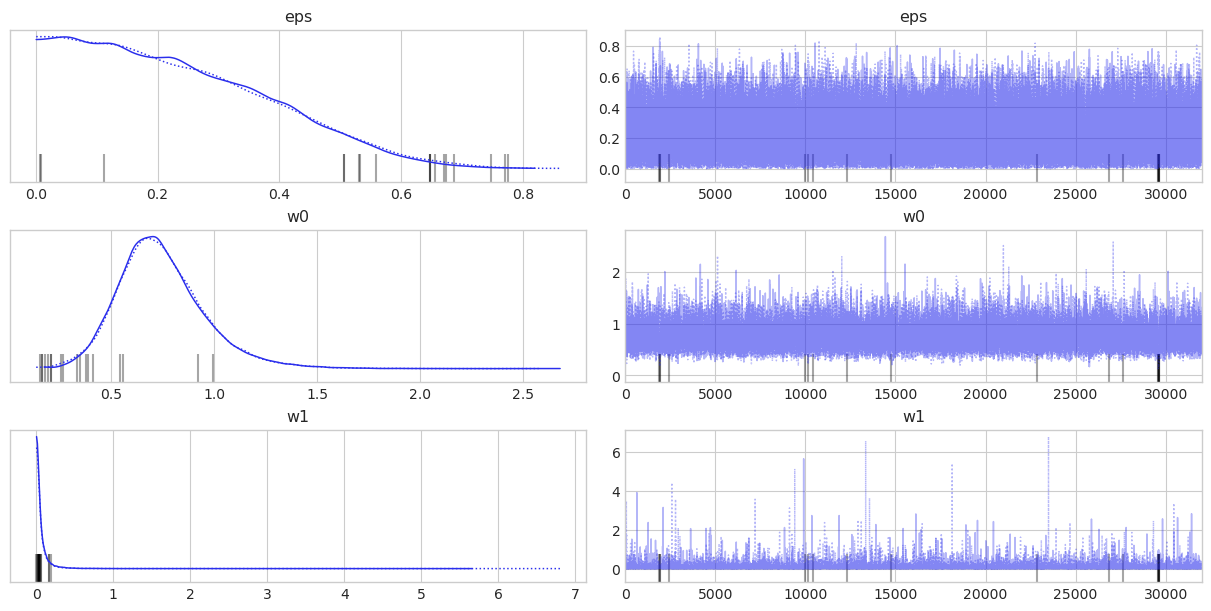

In [48]:
plot_trace(trace, ['eps', 'w0', 'w1'])

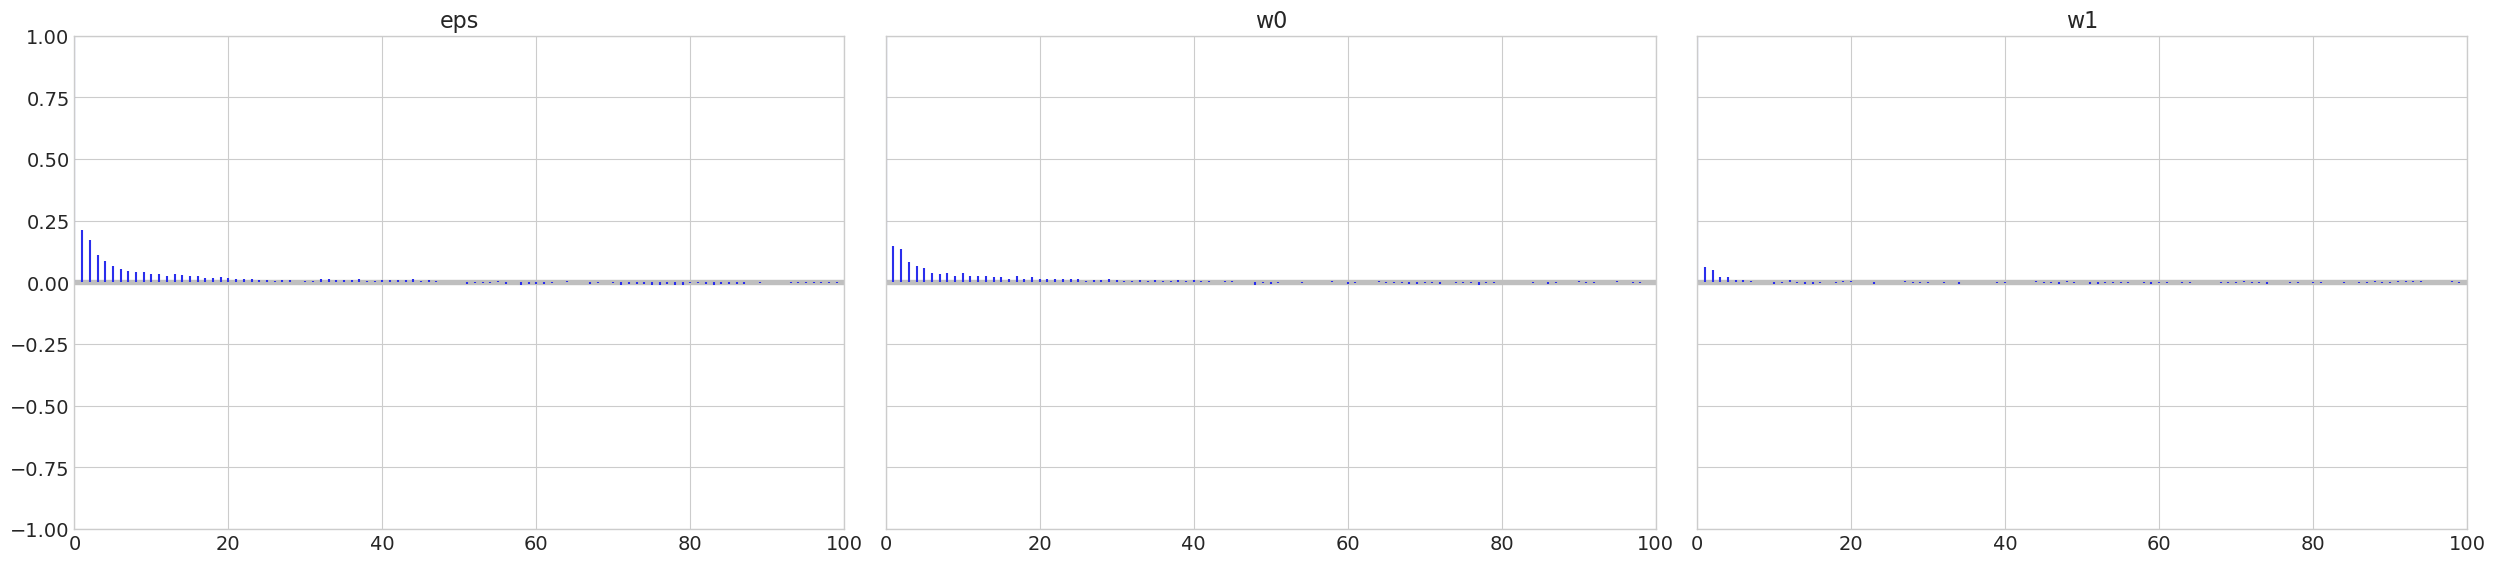

In [49]:
az.plot_autocorr(trace, var_names=['eps', 'w0', 'w1'], combined=True)
plt.show()

In [37]:
pred_samples = gp_model.sample_conditional(trace, x_std_data, 'f_pred', num_pred_samples=2048)

C:\Users\PasqualeDeMarinis\.conda\envs\pymc_env\lib\site-packages\pymc3\distributions\posterior_predictive.py:248: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


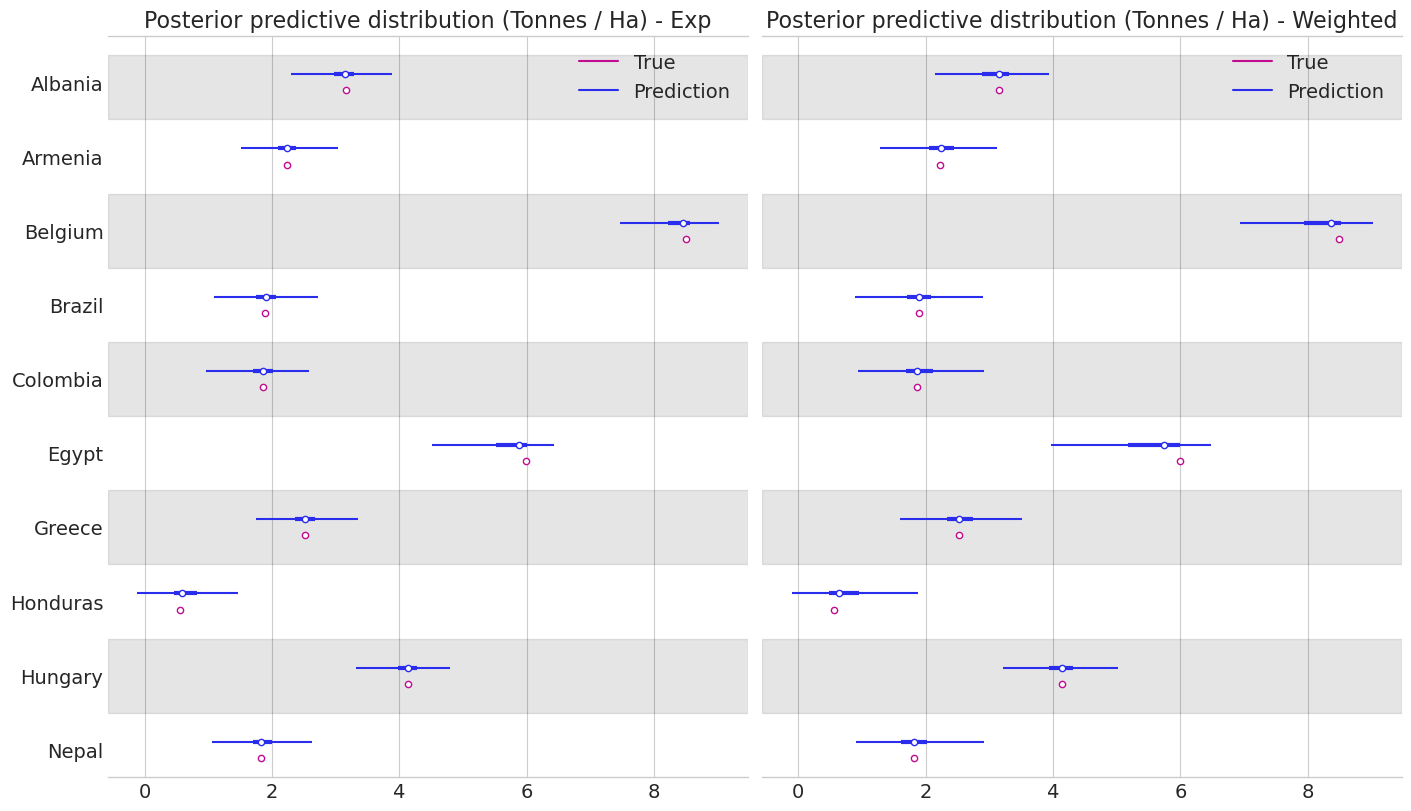

In [40]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 8), sharex=True, sharey=True)
plot_test(results['exp']['pred_samples'][:, test_indices], y_mean, y_stddev,
          y_test_data, countries[test_indices], axes=ax1, title='Posterior predictive distribution (Tonnes / Ha) - Exp')
plot_test(pred_samples[:, test_indices], y_mean, y_stddev,
          y_test_data, countries[test_indices], axes=ax2, title='Posterior predictive distribution (Tonnes / Ha) - Weighted')
plt.show()

In [39]:
mae, r2 = compute_metrics(pred_samples, y_mean, y_stddev, y_data, show=False)
print("Exp     : R2: {} \t MAE: {}".format(results['exp']['r2'], results['exp']['mae']))
print("Weighted: R2: {} \t MAE: {}".format(r2, mae))

Exp     : R2: 0.9996265968624055 	 MAE: 267.34241049891403
Weighted: R2: 0.9982305955931667 	 MAE: 520.0315283280298


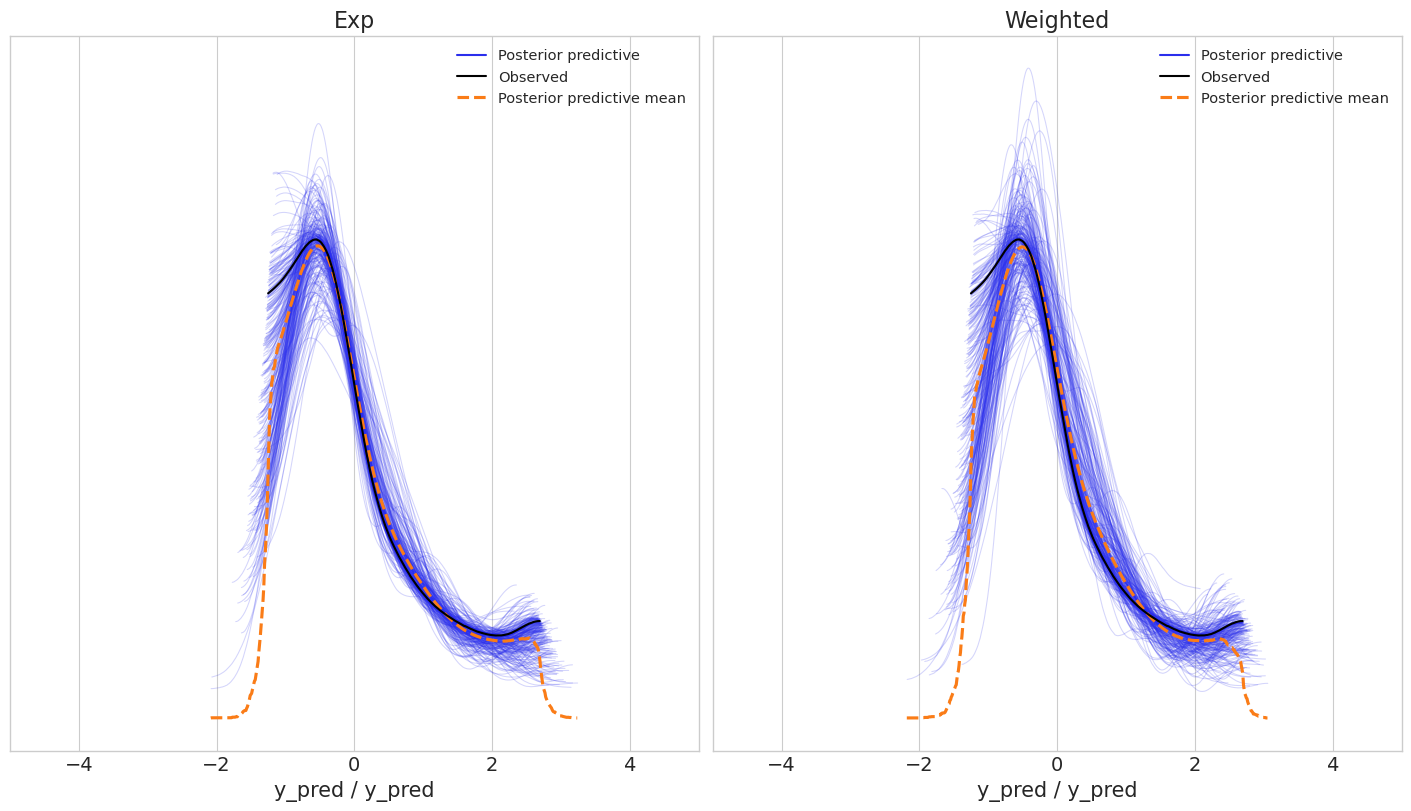

In [41]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 8), sharex=True, sharey=True)
ax1.set_title('Exp')
ax2.set_title('Weighted')

ppc_data = az.from_pymc3(posterior_predictive={'y_pred':results['exp']['pred_samples']}, model=model)
az.plot_ppc(ppc_data, num_pp_samples=256, ax=ax1)
ax1.set_xlim((-5, 5))
plt.plot()

ppc_data = az.from_pymc3(posterior_predictive={'y_pred':pred_samples}, model=model)
az.plot_ppc(ppc_data, num_pp_samples=256, ax=ax2)
ax1.set_xlim((-5, 5))
plt.plot()
plt.show()

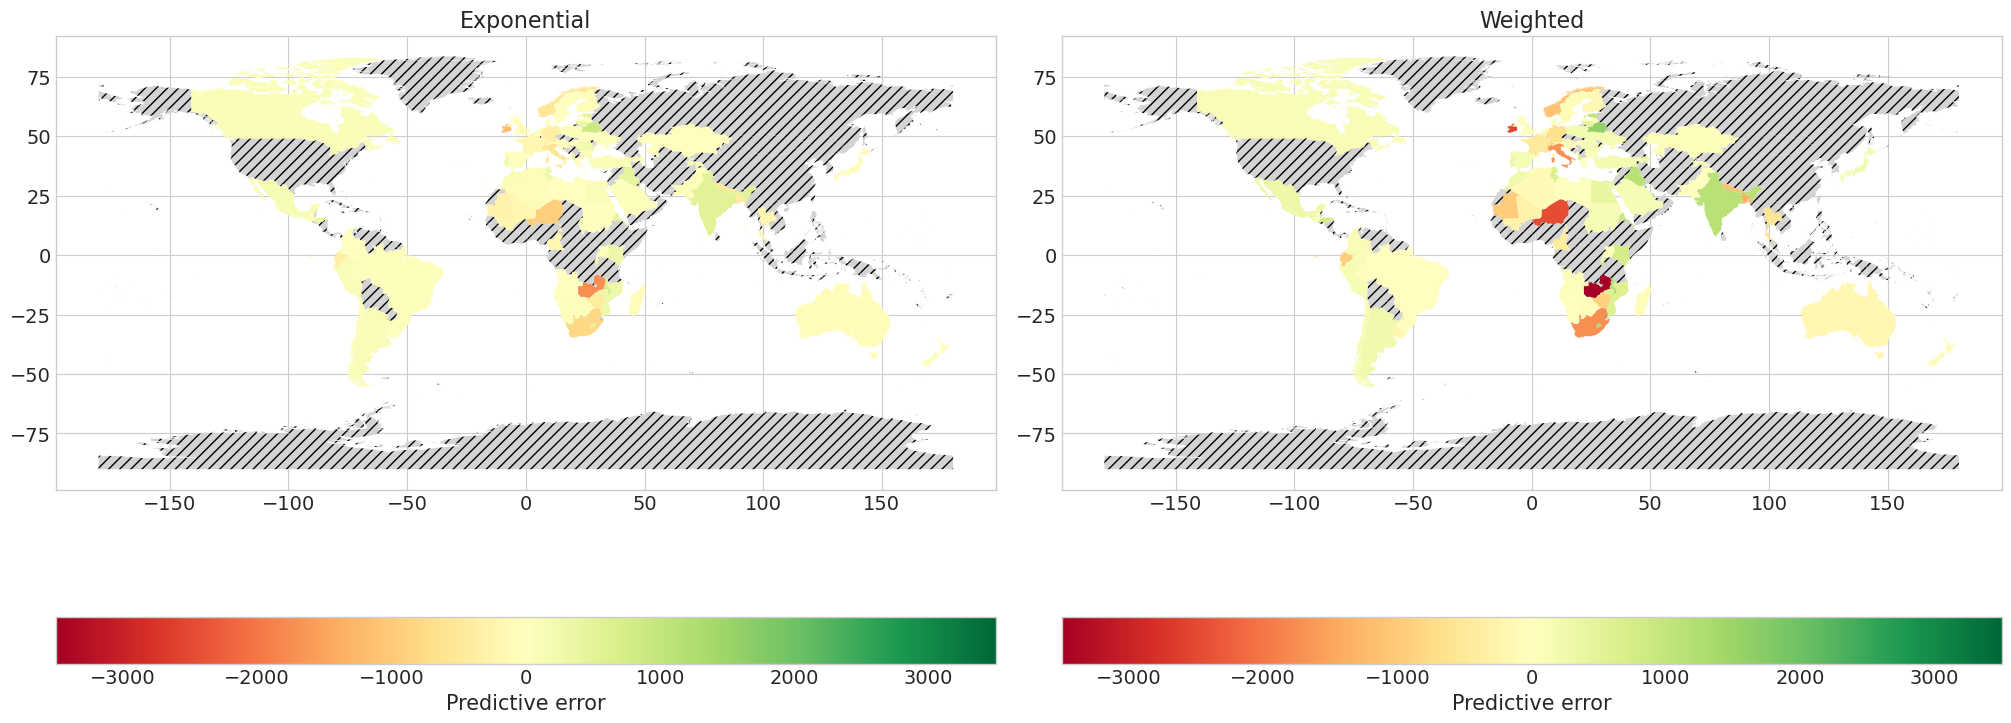

In [42]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 20))
ax1.set_title('Exponential')
ax2.set_title('Weighted')
world_error_plot(world, results['exp']['pred_samples'], y_mean, y_stddev, y_data, axes=ax1, max_error=3500)
world_error_plot(world, pred_samples, y_mean, y_stddev, y_data, axes=ax2, max_error=3500)
plt.show()

In [43]:
results['exp_linear_weighted'] = {
    'trace': trace,
    'pred_samples': pred_samples,
    'mae': mae,
    'r2': r2,
}

# Conclusions
<font size=5>
    
- GPs are more expressive than classic Bayesian models
- Can fit better data distributions
    - Recap on errors of models
<br><br>
- Require a significant greater amount of time to fit
    - Matrix inversion calucalations required for each sample
- Require more parameter tuning 
    - Less computationally stable -> they diverge more easily

## Load and save results

In [6]:
results = {}

In [4]:
# Load results
with open('yp_wheat.pickle', 'rb') as handle:
    results = pickle.load(handle)

In [49]:
# Save results
with open('yp_wheat.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [45]:
rs = results['exp']
trace = rs['trace']
pred_samples = rs['pred_samples']
mae = rs['mae']
r2 = rs['r2']

In [48]:
results.keys()

dict_keys(['expquad', 'poly', 'exp', 'ratquad', 'exp_linear_weighted'])

In [46]:
rs = results['matern32']
trace = rs['trace']
pred_samples = rs['pred_samples']
mae = rs['mae']
r2 = rs['r2']